In [ ]:
!pip install gensim --upgrade

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import gensim.downloader
import torch
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from gru import GRUGrader
from trainer import train_grader
from eval_metric import *
from dataset import EssayDataset, essay_collate_fn

Data Preparation

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/cs7641/train_tokenized.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-200')
glove_dict = glove_vectors.key_to_index
len(glove_dict)

[==================================================] 100.0% 252.1/252.1MB downloaded


400000

In [ ]:
#Vector Array
gensim_emb_weights = glove_vectors.vectors
gensim_emb_weights.shape

(400000, 200)

In [ ]:
data['list_lower_word_token_nltk'] = data['word_token_nltk'].apply(eval)
data['list_lower_word_token_nltk'] = data['list_lower_word_token_nltk'].apply(lambda l: [e.lower() for e in l if e not in ('', ' ')])
data['num_valid_token'] = data['list_lower_word_token_nltk'].apply(lambda x: len([c for c in x if c in glove_dict]))
data['num_all_token'] = data['list_lower_word_token_nltk'].apply(len)
data['unrecgonized_tokens'] = data['list_lower_word_token_nltk'].apply(lambda x: [c for c in x if c not in glove_dict])
data["word_token_nltk_idx"] = data['list_lower_word_token_nltk'].apply(
    lambda x: [glove_vectors.key_to_index[c]  if c in glove_dict else 400000 for c in x])

In [ ]:
task_cols = ["cohesion","syntax","vocabulary", 
    "phraseology", "grammar", "conventions"]
data.loc[1, task_cols].to_list()

[2.5, 2.5, 3.0, 2.0, 2.0, 2.5]

In [ ]:
df_train, df_valid, df_test = np.split(
    data[["text_id", "full_text", "word_token_nltk_idx"] + task_cols].sample(
        frac=1, random_state=42), 
    [int(.8*len(data)), int(.9*len(data))])

In [ ]:
BATCH_SIZE = 128
np.random.seed(42)

In [ ]:
ds_test = EssayDataset(df_test, "word_token_nltk_idx", task_cols)
dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=BATCH_SIZE, 
    shuffle=True, collate_fn=essay_collate_fn)

In [ ]:
# gru_grader = GRUGrader(gensim_emb_weights=gensim_emb_weights, **params)
# best_model = train_grader(dl_train, dl_valid, 
#         model=gru_grader,
#         model_name=name,
#         save_path="drive/MyDrive/data/cs7641/rnn_models",
#         loss_func=torch.nn.MSELoss(),
#         opt=torch.optim.Adam(gru_grader.parameters(), lr=0.001),
#         epochs=30)

In [ ]:
model_versions = {
    # Default
    "gru_64_6__bidirectiona_True__decoder_3":{
        "gru_size":64,
        "gru_num_layer":6,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    # Experiment with gru size
    "gru_32_6__bidirectiona_True__decoder_3":{
        "gru_size":32,
        "gru_num_layer":6,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    "gru_128_6__bidirectiona_True__decoder_3":{
        "gru_size":128,
        "gru_num_layer":6,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    # Experiment with gru depth
    "gru_64_4__bidirectiona_True__decoder_3":{
        "gru_size":64,
        "gru_num_layer":4,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    "gru_64_8__bidirectiona_True__decoder_3":{
        "gru_size":64,
        "gru_num_layer":8,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    # Experiment with bidirectional = False
    "gru_64_6__bidirectiona_False__decoder_3":{
        "gru_size":64,
        "gru_num_layer":6,
        "bidirectional":False,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    # Experiment with decoder depth
    "gru_64_6__bidirectiona_True__decoder_2":{
        "gru_size":64,
        "gru_num_layer":6,
        "bidirectional":True,
        "decoder_depth":2,
        "decoder_size":[256,64]
    },
    "gru_64_6__bidirectiona_True__decoder_4":{
        "gru_size":64,
        "gru_num_layer":6,
        "bidirectional":True,
        "decoder_depth":4,
        "decoder_size":[256, 512, 128, 64]
    },
    # # Experiment with gru depth
    "gru_64_12__bidirectiona_True__decoder_3":{
        "gru_size":64,
        "gru_num_layer":12,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    "gru_64_16__bidirectiona_True__decoder_3":{
        "gru_size":64,
        "gru_num_layer":16,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[256, 512, 64]
    },
    # Experiment with decoder size
    "gru_64_12__bidirectiona_True__decoder_3_lite":{
        "gru_size":64,
        "gru_num_layer":12,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[128, 256, 64]
    },
    "gru_64_16__bidirectiona_True__decoder_3_lite":{
        "gru_size":64,
        "gru_num_layer":16,
        "bidirectional":True,
        "decoder_depth":3,
        "decoder_size":[128, 256, 64]
    },
    # Experiment with decoder depth
    "gru_64_12__bidirectiona_True__decoder_4_lite":{
        "gru_size":64,
        "gru_num_layer":12,
        "bidirectional":True,
        "decoder_depth":4,
        "decoder_size":[128, 256, 128, 64]
    },
    "gru_64_16__bidirectiona_True__decoder_4_lite":{
        "gru_size":64,
        "gru_num_layer":16,
        "bidirectional":True,
        "decoder_depth":4,
        "decoder_size":[128, 256, 128, 64]
    },

}

In [ ]:
model_names = model_versions.keys()
model_names

dict_keys(['gru_64_6__bidirectiona_True__decoder_3', 'gru_32_6__bidirectiona_True__decoder_3', 'gru_128_6__bidirectiona_True__decoder_3', 'gru_64_4__bidirectiona_True__decoder_3', 'gru_64_8__bidirectiona_True__decoder_3', 'gru_64_6__bidirectiona_False__decoder_3', 'gru_64_6__bidirectiona_True__decoder_2', 'gru_64_6__bidirectiona_True__decoder_4', 'gru_64_12__bidirectiona_True__decoder_3', 'gru_64_16__bidirectiona_True__decoder_3', 'gru_64_12__bidirectiona_True__decoder_3_lite', 'gru_64_16__bidirectiona_True__decoder_3_lite', 'gru_64_12__bidirectiona_True__decoder_4_lite', 'gru_64_16__bidirectiona_True__decoder_4_lite'])

In [ ]:
pred_cols = ["cohesion_pred","syntax_pred","vocabulary_pred", "phraseology_pred", "grammar_pred", "conventions_pred"]
actual_cols = ["cohesion","syntax","vocabulary", "phraseology", "grammar", "conventions"]

model_mcrmse = []
cohesion_rmse = []
syntax_rmse = []
vocabulary_rmse = []
phraseology_rmse = []
grammar_rmse = []
conventions_rmse = []
for i in model_names:
  model_path = 'best_' + i
  model = GRUGrader(gensim_emb_weights=gensim_emb_weights, **model_versions[i])
  model.load_state_dict(torch.load("/content/drive/MyDrive/cs7641/rnn_models/"+ model_path +'.pt'))
  model.eval()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  test_pred = torch.concat([
    model([xb.to(device), sb.to(device)]) for ([xb, sb]), _ in dl_test]
    ).cpu().detach().numpy()
  

  pred_df = pd.DataFrame(data= test_pred, columns = pred_cols)
  ##Joining Prediction Results to Actual test Data
  a= df_test
  final_test = (a.reset_index()).join(pred_df)
  final_test.shape

  model_mcrmse.append(mcrmse(final_test, actual_cols, pred_cols))
  
  cohesion_rmse.append(rmse(final_test,"cohesion","cohesion_pred"))
  syntax_rmse.append(rmse(final_test,"syntax","syntax_pred"))
  vocabulary_rmse.append(rmse(final_test,"vocabulary","vocabulary_pred"))
  phraseology_rmse.append(rmse(final_test,"phraseology","phraseology_pred"))
  grammar_rmse.append(rmse(final_test,"grammar","grammar_pred"))
  conventions_rmse.append(rmse(final_test,"conventions","cohesion_pred"))
  print("Iteration",i,"completed!!")

Iteration gru_64_6__bidirectiona_True__decoder_3 completed!!
Iteration gru_32_6__bidirectiona_True__decoder_3 completed!!
Iteration gru_128_6__bidirectiona_True__decoder_3 completed!!
Iteration gru_64_4__bidirectiona_True__decoder_3 completed!!
Iteration gru_64_8__bidirectiona_True__decoder_3 completed!!
Iteration gru_64_6__bidirectiona_False__decoder_3 completed!!
Iteration gru_64_6__bidirectiona_True__decoder_2 completed!!
Iteration gru_64_6__bidirectiona_True__decoder_4 completed!!
Iteration gru_64_12__bidirectiona_True__decoder_3 completed!!
Iteration gru_64_16__bidirectiona_True__decoder_3 completed!!
Iteration gru_64_12__bidirectiona_True__decoder_3_lite completed!!
Iteration gru_64_16__bidirectiona_True__decoder_3_lite completed!!
Iteration gru_64_12__bidirectiona_True__decoder_4_lite completed!!
Iteration gru_64_16__bidirectiona_True__decoder_4_lite completed!!


In [ ]:
plot_names= []
for i in range(len(model_names)):
  plot_names.append("M-"+str(i+1))

**Model Plot**

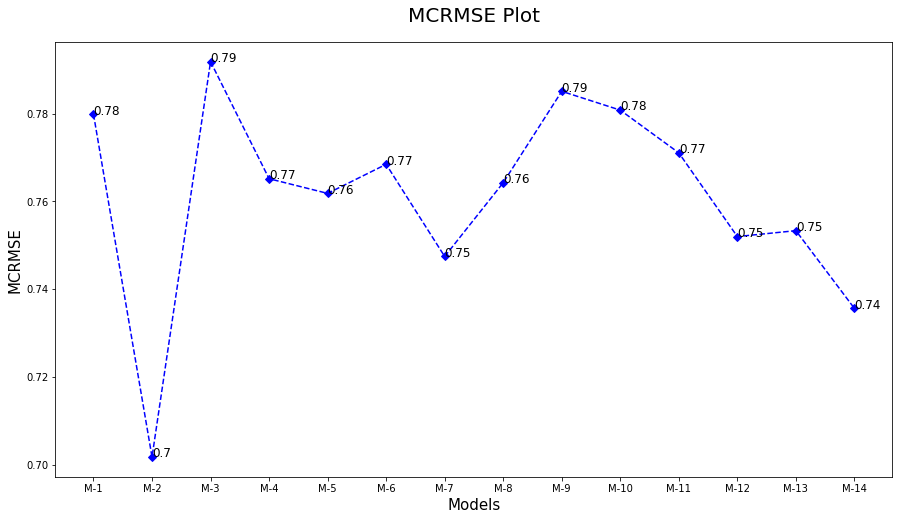

In [ ]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(plot_names,model_mcrmse, '--', color = 'b', marker = 'D')
ax.set_ylabel("MCRMSE", fontsize = 15)
ax.set_xlabel("Models", fontsize = 15)
ax.set_title("MCRMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax.text(plot_names[index], model_mcrmse[index], round(model_mcrmse[index],2), size=12)


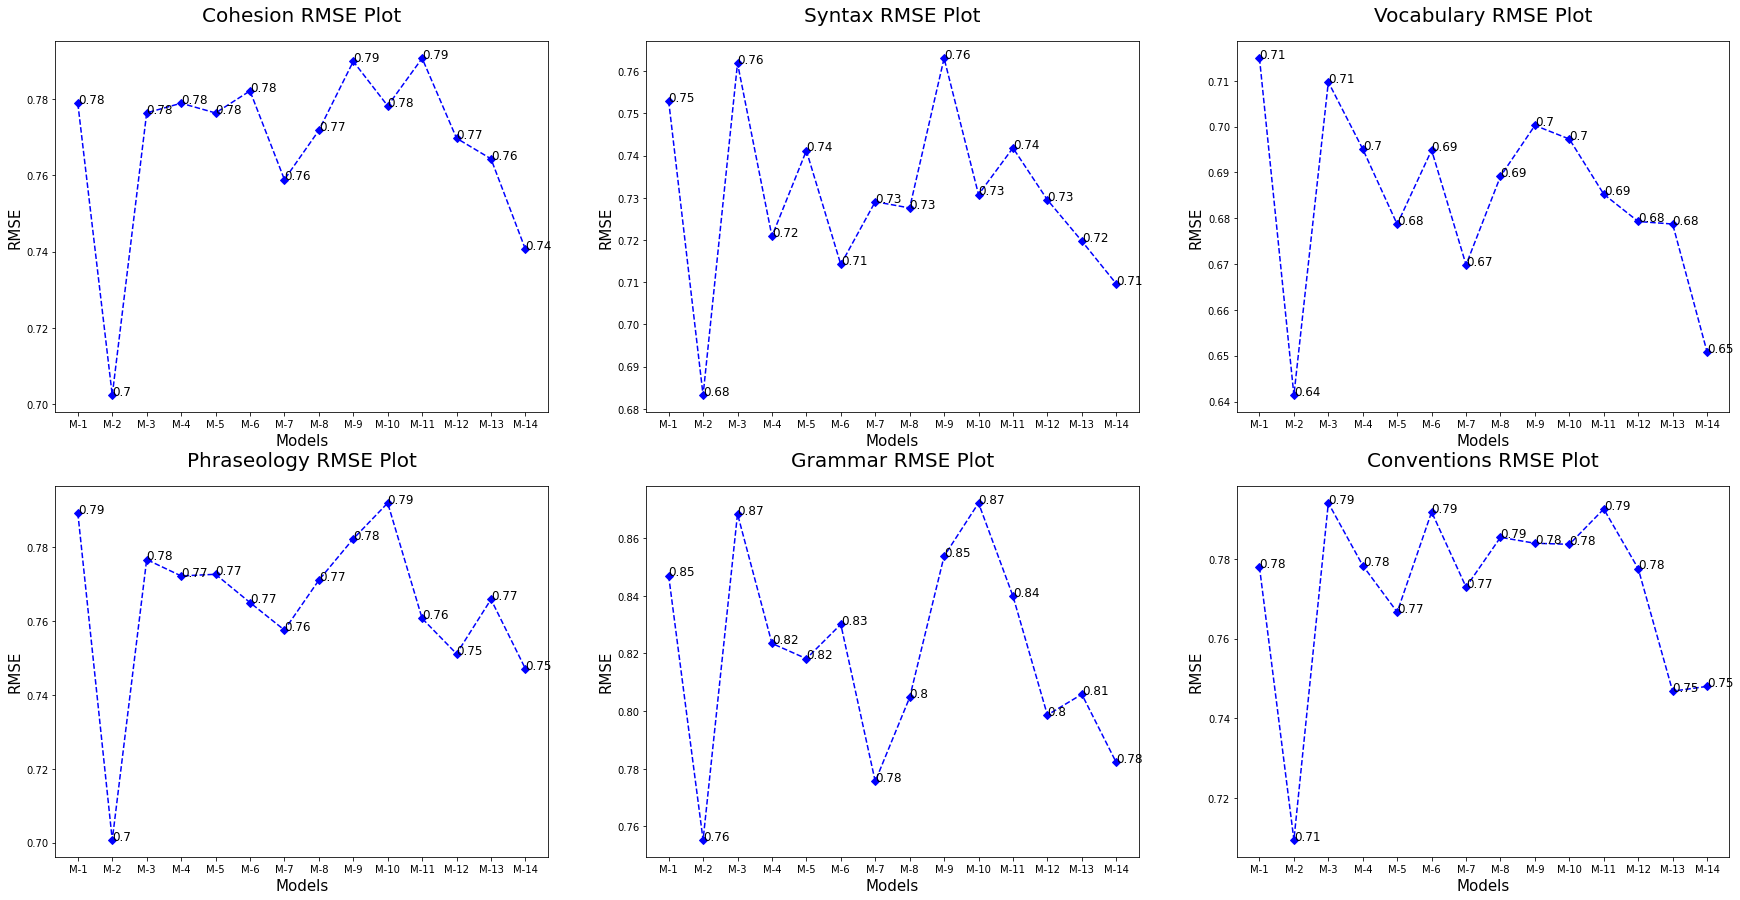

In [ ]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(30,15))


ax[0,0].plot(plot_names,cohesion_rmse, '--', color = 'b', marker = 'D')
ax[0,0].set_ylabel("RMSE", fontsize = 15)
ax[0,0].set_xlabel("Models", fontsize = 15)
ax[0,0].set_title("Cohesion RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,0].text(plot_names[index], cohesion_rmse[index], round(cohesion_rmse[index],2), size=12)

ax[0,1].plot(plot_names,syntax_rmse, '--', color = 'b', marker = 'D')
ax[0,1].set_ylabel("RMSE", fontsize = 15)
ax[0,1].set_xlabel("Models", fontsize = 15)
ax[0,1].set_title("Syntax RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,1].text(plot_names[index], syntax_rmse[index], round(syntax_rmse[index],2), size=12)

ax[0,2].plot(plot_names,vocabulary_rmse, '--', color = 'b', marker = 'D')
ax[0,2].set_ylabel("RMSE", fontsize = 15)
ax[0,2].set_xlabel("Models", fontsize = 15)
ax[0,2].set_title("Vocabulary RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,2].text(plot_names[index], vocabulary_rmse[index], round(vocabulary_rmse[index],2), size=12)

ax[1,0].plot(plot_names,phraseology_rmse, '--', color = 'b', marker = 'D')
ax[1,0].set_ylabel("RMSE", fontsize = 15)
ax[1,0].set_xlabel("Models", fontsize = 15)
ax[1,0].set_title("Phraseology RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,0].text(plot_names[index], phraseology_rmse[index], round(phraseology_rmse[index],2), size=12)

ax[1,1].plot(plot_names,grammar_rmse, '--', color = 'b', marker = 'D')
ax[1,1].set_ylabel("RMSE", fontsize = 15)
ax[1,1].set_xlabel("Models", fontsize = 15)
ax[1,1].set_title("Grammar RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,1].text(plot_names[index], grammar_rmse[index], round(grammar_rmse[index],2), size=12)

ax[1,2].plot(plot_names,conventions_rmse, '--', color = 'b', marker = 'D')
ax[1,2].set_ylabel("RMSE", fontsize = 15)
ax[1,2].set_xlabel("Models", fontsize = 15)
ax[1,2].set_title("Conventions RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,2].text(plot_names[index], conventions_rmse[index], round(conventions_rmse[index],2), size=12)

plt.show()

In [ ]:
results_table = pd.DataFrame(
    {"Plot Names":plot_names,
     "Model":model_names,
     "MCRMSE": model_mcrmse,
     "Cohesion RMSE": cohesion_rmse,
     "Syntax RMSE": syntax_rmse,
     "Vocabulary RMSE": vocabulary_rmse,
     "Phraseology RMSE": phraseology_rmse,
     "Grammar RMSE": grammar_rmse,
     "Conventions RMSE": conventions_rmse

     }
)
results_table

,Plot Names,Model,MCRMSE,Cohesion RMSE,Syntax RMSE,Vocabulary RMSE,Phraseology RMSE,Grammar RMSE,Conventions RMSE
0,M-1,gru_64_6__bidirectiona_True__decoder_3,0.779851,0.778859,0.752946,0.714907,0.789276,0.847007,0.777938
1,M-2,gru_32_6__bidirectiona_True__decoder_3,0.701760,0.702312,0.683228,0.641378,0.700712,0.755265,0.709449
2,M-3,gru_128_6__bidirectiona_True__decoder_3,0.791826,0.776402,0.761864,0.709713,0.776681,0.868436,0.794016
3,M-4,gru_64_4__bidirectiona_True__decoder_3,0.765165,0.778922,0.720879,0.695084,0.772242,0.823495,0.778321
4,M-5,gru_64_8__bidirectiona_True__decoder_3,0.761821,0.776370,0.741157,0.678670,0.772690,0.818195,0.766639
5,M-6,gru_64_6__bidirectiona_False__decoder_3,0.768446,0.782157,0.714193,0.694855,0.765032,0.830121,0.791768
6,M-7,gru_64_6__bidirectiona_True__decoder_2,0.747449,0.758894,0.729065,0.669824,0.757578,0.775591,0.772921
7,M-8,gru_64_6__bidirectiona_True__decoder_4,0.764256,0.771787,0.727583,0.689148,0.771089,0.804736,0.785409
8,M-9,gru_64_12__bidirectiona_True__decoder_3,0.785077,0.789898,0.763050,0.700244,0.782301,0.853763,0.783915
9,M-10,gru_64_16__bidirectiona_True__decoder_3,0.780789,0.778232,0.730759,0.697275,0.791998,0.872237,0.783651


Baseline Model Performance

In [ ]:
plot_names = ["Lasso Regression", "XGBoost","Random Forest"]
model_mcrmse = [.595, .583, .668]
cohesion_rmse = [.62,.61,.62]
syntax_rmse = [.6,.59,.59]
vocabulary_rmse = [.55,.54,.54]
phraseology_rmse = [.6,.6,.6]
grammar_rmse = [.62,60,.61]
conventions_rmse = [.58,.56,.56]
hollistic_score = [0.59,0.49,0.49]


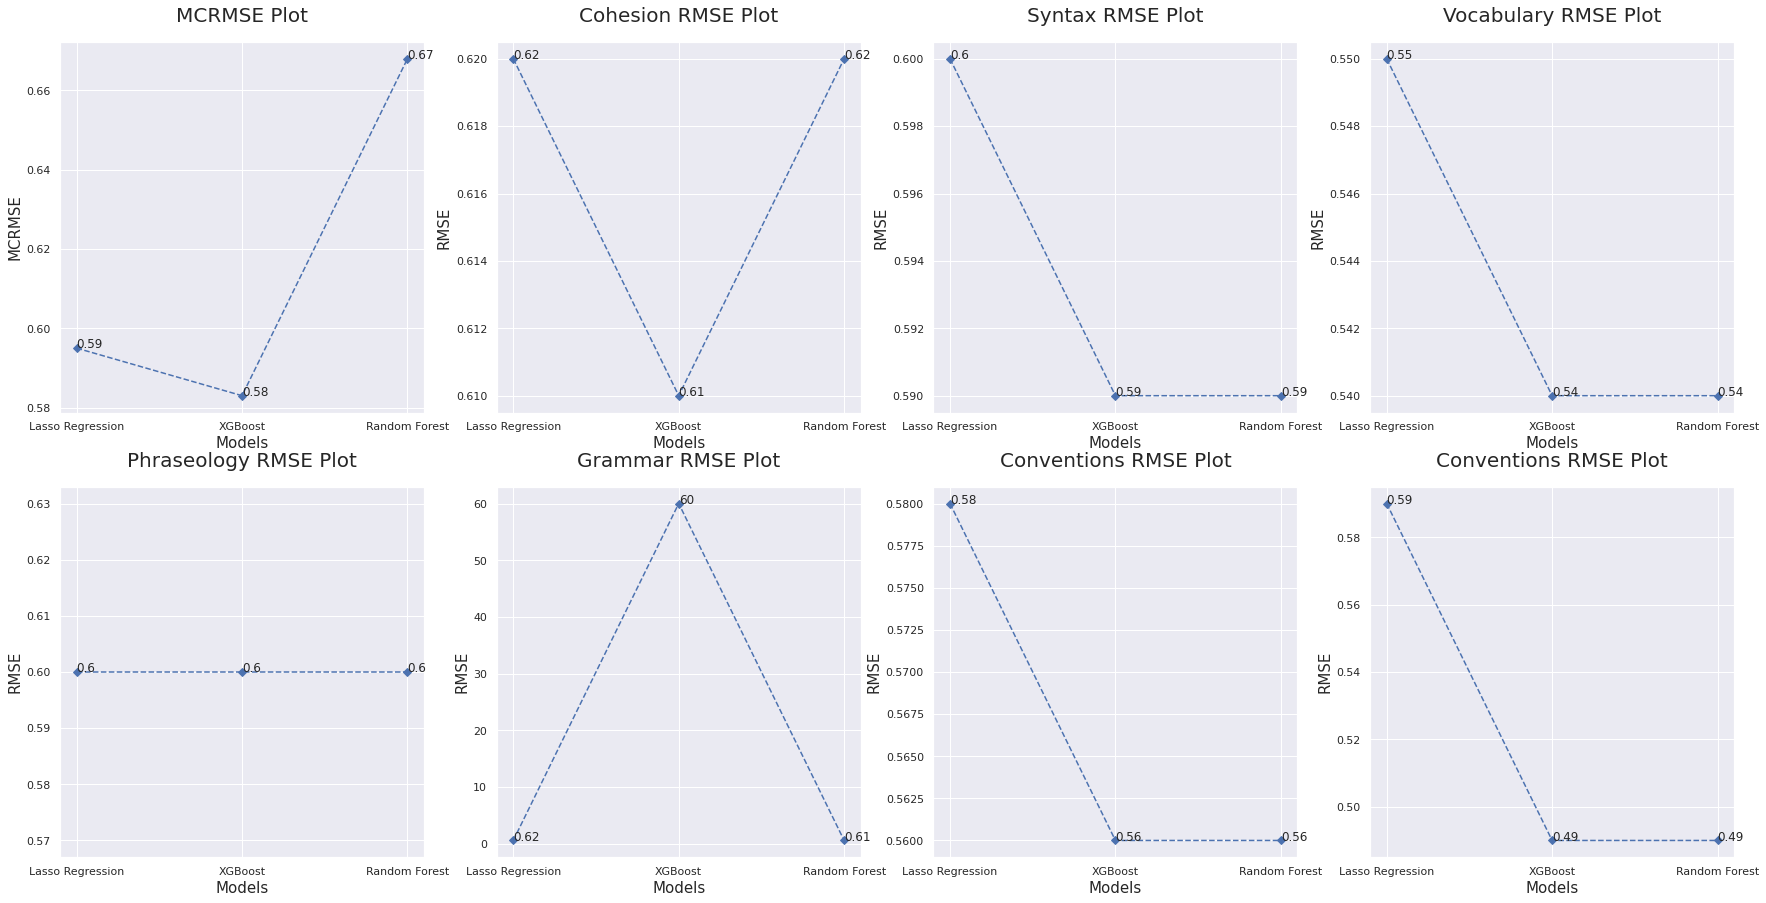

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,4,figsize=(30,15))
ax[0,0].plot(plot_names,model_mcrmse, '--', color = 'b', marker = 'D')
ax[0,0].set_ylabel("MCRMSE", fontsize = 15)
ax[0,0].set_xlabel("Models", fontsize = 15)
ax[0,0].set_title("MCRMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,0].text(plot_names[index], model_mcrmse[index], round(model_mcrmse[index],2), size=12)

ax[0,1].plot(plot_names,cohesion_rmse, '--', color = 'b', marker = 'D')
ax[0,1].set_ylabel("RMSE", fontsize = 15)
ax[0,1].set_xlabel("Models", fontsize = 15)
ax[0,1].set_title("Cohesion RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,1].text(plot_names[index], cohesion_rmse[index], round(cohesion_rmse[index],2), size=12)

ax[0,2].plot(plot_names,syntax_rmse, '--', color = 'b', marker = 'D')
ax[0,2].set_ylabel("RMSE", fontsize = 15)
ax[0,2].set_xlabel("Models", fontsize = 15)
ax[0,2].set_title("Syntax RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,2].text(plot_names[index], syntax_rmse[index], round(syntax_rmse[index],2), size=12)

ax[0,3].plot(plot_names,vocabulary_rmse, '--', color = 'b', marker = 'D')
ax[0,3].set_ylabel("RMSE", fontsize = 15)
ax[0,3].set_xlabel("Models", fontsize = 15)
ax[0,3].set_title("Vocabulary RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[0,3].text(plot_names[index], vocabulary_rmse[index], round(vocabulary_rmse[index],2), size=12)

ax[1,0].plot(plot_names,phraseology_rmse, '--', color = 'b', marker = 'D')
ax[1,0].set_ylabel("RMSE", fontsize = 15)
ax[1,0].set_xlabel("Models", fontsize = 15)
ax[1,0].set_title("Phraseology RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,0].text(plot_names[index], phraseology_rmse[index], round(phraseology_rmse[index],2), size=12)

ax[1,1].plot(plot_names,grammar_rmse, '--', color = 'b', marker = 'D')
ax[1,1].set_ylabel("RMSE", fontsize = 15)
ax[1,1].set_xlabel("Models", fontsize = 15)
ax[1,1].set_title("Grammar RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,1].text(plot_names[index], grammar_rmse[index], round(grammar_rmse[index],2), size=12)

ax[1,2].plot(plot_names,conventions_rmse, '--', color = 'b', marker = 'D')
ax[1,2].set_ylabel("RMSE", fontsize = 15)
ax[1,2].set_xlabel("Models", fontsize = 15)
ax[1,2].set_title("Conventions RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,2].text(plot_names[index], conventions_rmse[index], round(conventions_rmse[index],2), size=12)

ax[1,3].plot(plot_names,hollistic_score, '--', color = 'b', marker = 'D')
ax[1,3].set_ylabel("RMSE", fontsize = 15)
ax[1,3].set_xlabel("Models", fontsize = 15)
ax[1,3].set_title("Conventions RMSE Plot", fontsize = 20, pad = 20)
for index in range(len(plot_names)):
  ax[1,3].text(plot_names[index], hollistic_score[index], round(hollistic_score[index],2), size=12)

plt.show()